In [2]:
import math
import time

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

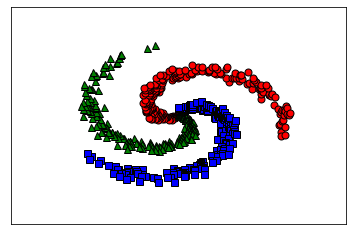

In [6]:

N = 200 # number of points per class
d0 = 2 # dimensionality
C = 3 # number of classes
X = np.zeros((N*C, d0)) # data matrix (each row = single example)
y = np.zeros(N*C, dtype='uint8') # class labels

for j in range(C):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
# plt.scatter(X[:N, 0], X[:N, 1], c=y[:N], s=40, cmap=plt.cm.Spectral)

plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7, markeredgecolor = 'k');
plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'ro', markersize = 7, markeredgecolor = 'k');
plt.plot(X[2*N:, 0], X[2*N:, 1], 'g^', markersize = 7, markeredgecolor = 'k');
# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])
plt.show()

In [3]:
X.shape, y.shape

((300, 2), (300,))

In [4]:
def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each row of Z is a set of scores.    
    """
    e_Z = np.exp(Z - np.max(Z, axis = 1, keepdims = True))
    A = e_Z / e_Z.sum(axis = 1, keepdims = True)
    return A

def crossentropy_loss(Yhat, y):
    """
    Yhat: a numpy array of shape (Npoints, nClasses) -- predicted output 
    y: a numpy array of shape (Npoints) -- ground truth. We don't need to use 
    the one-hot vector here since most of elements are zeros. When programming 
    in numpy, we need to use the corresponding indexes only.
    """
    id0 = range(Yhat.shape[0])
    return -np.mean(np.log(Yhat[id0, y]))

In [5]:
def mlp_init(d0, d1, d2):
    """ 
    Initialize W1, b1, W2, b2 
    d0: dimension of input data 
    d1: number of hidden unit 
    d2: number of output unit = number of classes
    """
    W1 = 0.01*np.random.randn(d0, d1)
    b1 = np.zeros(d1)
    W2 = 0.01*np.random.randn(d1, d2)
    b2 = np.zeros(d2)
    return (W1, b1, W2, b2)

def mlp_predict(X, W1, b1, W2, b2):
    """
    Suppose that the network has been trained, predict class of new points. 
    X: data matrix, each ROW is one data point.
    W1, b1, W2, b2: learned weight matrices and biases 
    """
    Z1 = X.dot(W1) + b1    # shape (N, d1)
    A1 = np.maximum(Z1, 0) # shape (N, d1)
    Z2 = A1.dot(W2) + b2   # shape (N, d2)
    return np.argmax(Z2, axis=1)

def mlp_forward(X, W1, b1, W2, b2):
    # feedforward 
    Z1 = X.dot(W1) + b1       # shape (N, d1)
    A1 = np.maximum(Z1, 0)    # shape (N, d1)
    Z2 = A1.dot(W2) + b2      # shape (N, d2)
    Yhat = softmax_stable(Z2) # shape (N, d2)

    return Z1, A1, Z2, Yhat

def mlp_backward(X, y, Z1, A1, Yhat):
    # back propagation
    id0 = range(Yhat.shape[0])
    Yhat[id0, y] -=1 
    E2 = Yhat / X.shape[0]                # shape (N, d2)
    dW2 = np.dot(A1.T, E2)     # shape (d1, d2)
    db2 = np.sum(E2, axis = 0) # shape (d2,)
    E1 = np.dot(E2, W2.T)      # shape (N, d1)
    E1[Z1 <= 0] = 0            # gradient of ReLU, shape (N, d1)
    dW1 = np.dot(X.T, E1)      # shape (d0, d1)
    db1 = np.sum(E1, axis = 0) # shape (d1,)
    
    return dW1, db1, dW2, db2

def mlp_fit(X, y, W1, b1, W2, b2, eta, batchSize = 1, nIter = 10000):
    loss_hist = []
    
    for i in range(nIter):
        
        sampInd = np.random.choice(X.shape[0], (batchSize, ), replace = False)
        XFeed = X[sampInd, :]
        yFeed = y[sampInd]
        
        # feedforward 
        Z1, A1, Z2, Yhat = mlp_forward(XFeed, W1, b1, W2, b2)
        
        loss = crossentropy_loss(mlp_forward(X, W1, b1, W2, b2)[3], y)
        loss_hist.append(loss)
        if i % 1000 == 0: # print loss after each 1000 iterations
            print("iter %d, loss: %f" %(i, loss))
            
        # back propagation
        dW1, db1, dW2, db2 = mlp_backward(XFeed, yFeed, Z1, A1, Yhat)

        # Gradient Descent update
        W1 += -eta*dW1
        b1 += -eta*db1
        W2 += -eta*dW2
        b2 += -eta*db2
    return (W1, b1, W2, b2, loss_hist)

def mlp_gradTest(X, y, W1, b1, W2, b2, batchSize = 1, nIter = 10000):
    
    gradHistory = {
        'dW1': [],
        'db1': [],
        'dW2': [],
        'db2': [],
    }
    
    for i in range(nIter):
        
        sampInd = np.random.choice(X.shape[0], (batchSize, ), replace = False)
        XFeed = X[sampInd, :]
        yFeed = y[sampInd]
        
        # feedforward 
        Z1, A1, Z2, Yhat = mlp_forward(XFeed, W1, b1, W2, b2)
            
        # back propagation
        dW1, db1, dW2, db2 = mlp_backward(XFeed, yFeed, Z1, A1, Yhat)
        
        gradHistory['dW1'].append(dW1)
        gradHistory['db1'].append(db1)
        gradHistory['dW2'].append(dW2)
        gradHistory['db2'].append(db2)
    
    gradHistory['dW1'] = np.array(gradHistory['dW1'])
    gradHistory['db1'] = np.array(gradHistory['db1'])
    gradHistory['dW2'] = np.array(gradHistory['dW2'])
    gradHistory['db2'] = np.array(gradHistory['db2'])
    
    return gradHistory

def mlpSAGA(X, y, W1, b1, W2, b2, eta, nIter = 10000):
    
    loss_hist = []
    cache = createCacheSAGA(X, y, W1, b1, W2, b2)
    
    for i in range(nIter):
        
        sampInd = np.random.choice(X.shape[0], (1, ), replace = False)
        XFeed = X[sampInd, :]
        yFeed = y[sampInd]
        
        # feedforward 
        Z1, A1, Z2, Yhat = mlp_forward(XFeed, W1, b1, W2, b2)
        
        loss = crossentropy_loss(mlp_forward(X, W1, b1, W2, b2)[3], y)
        loss_hist.append(loss)
        if i % 1000 == 0: # print loss after each 1000 iterations
            print("iter %d, loss: %f" %(i, loss))
            
        # back propagation
        dW1, db1, dW2, db2 = mlp_backward(XFeed, yFeed, Z1, A1, Yhat)

        # Gradient Descent update
        W1 += -eta * (dW1 - cache['W1'][sampInd, :, :][0] + np.mean(cache['W1'], axis = 0))
        b1 += -eta * (db1 - cache['b1'][sampInd, :][0] + np.mean(cache['b1'], axis = 0))
        W2 += -eta * (dW2 - cache['W2'][sampInd, :, :][0] + np.mean(cache['W2'], axis = 0))
        b2 += -eta * (db2 - cache['b2'][sampInd, :][0] + np.mean(cache['b2'], axis = 0))
        
        cache['W1'][sampInd, :, :] = dW1
        cache['b1'][sampInd, :] = db1
        cache['W2'][sampInd, :, :] = dW2
        cache['b2'][sampInd, :] = db2
        
    return (W1, b1, W2, b2, loss_hist)

def createCacheSAGA(X, y, W1, b1, W2, b2):
    
    cache = {
        'W1': np.zeros((X.shape[0], W1.shape[0], W1.shape[1])),
        'b1': np.zeros((X.shape[0], b1.shape[0])),
        'W2': np.zeros((X.shape[0], W2.shape[0], W2.shape[1])),
        'b2': np.zeros((X.shape[0], b2.shape[0])),
    }
    
    for i in range(X.shape[0]):
        
        sampInd = np.array([i])
        
        # feedforward 
        Z1, A1, Z2, Yhat = mlp_forward(X[sampInd, :], W1, b1, W2, b2)
        
        # back propagation
        dW1, db1, dW2, db2 = mlp_backward(X[sampInd, :], y[i], Z1, A1, Yhat)
        
        cache['W1'][sampInd, :, :] = dW1
        cache['b1'][sampInd, :] = db1
        cache['W2'][sampInd, :, :] = dW2
        cache['b2'][sampInd, :] = db2
    
    return cache

def relativeError(a, b):
    return np.abs(a - b) / np.maximum(np.abs(a), np.abs(b))

In [6]:
d0 = 2
d1 = h = 100 # size of hidden layer
d2 = C = 3
eta = 1e-0 # learning rate
# initialize parameters randomly
(W1, b1, W2, b2) = mlp_init(d0, d1, d2)
(W1Full, b1Full, W2Full, b2Full) = deepcopy(W1), deepcopy(b1), deepcopy(W2), deepcopy(b2)
(W1Batch, b1Batch, W2Batch, b2Batch) = deepcopy(W1), deepcopy(b1), deepcopy(W2), deepcopy(b2)
(W1SAGA, b1SAGA, W2SAGA, b2SAGA) = deepcopy(W1), deepcopy(b1), deepcopy(W2), deepcopy(b2)

In [7]:
begin = time.time() 
(W1Full, b1Full, W2Full, b2Full, loss_histFull) = mlp_fit(X, y, W1Full, b1Full, W2Full, b2Full, 2, batchSize = X.shape[0], nIter = 100000)
end = time.time()

y_predFull = mlp_predict(X, W1Full, b1Full, W2Full, b2Full)
accFull = 100*np.mean(y_predFull == y)
print('training accuracy: %.2f %%' % accFull)
print('running time: %.8f' % (end - begin))

iter 0, loss: 1.098511
iter 1000, loss: 0.412348
iter 2000, loss: 0.265020
iter 3000, loss: 0.205755
iter 4000, loss: 0.173552
iter 5000, loss: 0.152590
iter 6000, loss: 0.137055
iter 7000, loss: 0.125130
iter 8000, loss: 0.115171
iter 9000, loss: 0.107072
iter 10000, loss: 0.100229
iter 11000, loss: 0.094399
iter 12000, loss: 0.089342
iter 13000, loss: 0.084871
iter 14000, loss: 0.081105
iter 15000, loss: 0.077864
iter 16000, loss: 0.074969
iter 17000, loss: 0.072382
iter 18000, loss: 0.070114
iter 19000, loss: 0.068127
iter 20000, loss: 0.066318
iter 21000, loss: 0.064670
iter 22000, loss: 0.063145
iter 23000, loss: 0.061723
iter 24000, loss: 0.060395
iter 25000, loss: 0.059206
iter 26000, loss: 0.058059
iter 27000, loss: 0.056937
iter 28000, loss: 0.055942
iter 29000, loss: 0.055010
iter 30000, loss: 0.054152
iter 31000, loss: 0.053301
iter 32000, loss: 0.052457
iter 33000, loss: 0.051657
iter 34000, loss: 0.050904
iter 35000, loss: 0.050160
iter 36000, loss: 0.049436
iter 37000, lo

In [8]:
begin = time.time() 
(W1Batch, b1Batch, W2Batch, b2Batch, loss_histBatch) = mlp_fit(X, y, W1Batch, b1Batch, W2Batch, b2Batch, 4e-1, batchSize = 1, nIter = 100000)
end = time.time()

y_predBatch = mlp_predict(X, W1Batch, b1Batch, W2Batch, b2Batch)
accBatch = 100*np.mean(y_predBatch == y)
print('training accuracy: %.2f %%' % accBatch)
print('running time: %.8f' % (end - begin))

iter 0, loss: 1.098511
iter 1000, loss: 0.835423
iter 2000, loss: 0.759527
iter 3000, loss: 0.791461
iter 4000, loss: 0.603666
iter 5000, loss: 0.790580
iter 6000, loss: 0.559035
iter 7000, loss: 0.446160
iter 8000, loss: 0.645108
iter 9000, loss: 0.446761
iter 10000, loss: 0.437225
iter 11000, loss: 0.555009
iter 12000, loss: 0.300527
iter 13000, loss: 0.302960
iter 14000, loss: 0.384846
iter 15000, loss: 0.307456
iter 16000, loss: 0.230315
iter 17000, loss: 0.261739
iter 18000, loss: 0.282495
iter 19000, loss: 0.334083
iter 20000, loss: 0.285447
iter 21000, loss: 0.223824
iter 22000, loss: 0.167837
iter 23000, loss: 0.208981
iter 24000, loss: 0.295827
iter 25000, loss: 0.267163
iter 26000, loss: 0.232386
iter 27000, loss: 0.305398
iter 28000, loss: 0.206521
iter 29000, loss: 0.240633
iter 30000, loss: 0.182092
iter 31000, loss: 0.208874
iter 32000, loss: 0.227411
iter 33000, loss: 0.175542
iter 34000, loss: 0.182939
iter 35000, loss: 0.320317
iter 36000, loss: 0.179055
iter 37000, lo

In [9]:
begin = time.time() 
(W1SAGA, b1SAGA, W2SAGA, b2SAGA, loss_histSAGA) = mlpSAGA(X, y, W1SAGA, b1SAGA, W2SAGA, b2SAGA, 5.25e-1, nIter = 100000)
end = time.time()

y_predSAGA = mlp_predict(X, W1SAGA, b1SAGA, W2SAGA, b2SAGA)
accSAGA = 100*np.mean(y_predSAGA == y)
print('training accuracy: %.2f %%' % accSAGA)
print('running time: %.8f' % (end - begin))

iter 0, loss: 1.098511
iter 1000, loss: 0.677409
iter 2000, loss: 0.581455
iter 3000, loss: 0.485115
iter 4000, loss: 0.406551
iter 5000, loss: 0.345530
iter 6000, loss: 0.301318
iter 7000, loss: 0.265191
iter 8000, loss: 0.237277
iter 9000, loss: 0.214928
iter 10000, loss: 0.195749
iter 11000, loss: 0.180137
iter 12000, loss: 0.166892
iter 13000, loss: 0.155701
iter 14000, loss: 0.146247
iter 15000, loss: 0.137557
iter 16000, loss: 0.130306
iter 17000, loss: 0.124558
iter 18000, loss: 0.118711
iter 19000, loss: 0.113792
iter 20000, loss: 0.109437
iter 21000, loss: 0.105506
iter 22000, loss: 0.101882
iter 23000, loss: 0.098566
iter 24000, loss: 0.095537
iter 25000, loss: 0.092766
iter 26000, loss: 0.090252
iter 27000, loss: 0.087900
iter 28000, loss: 0.085757
iter 29000, loss: 0.083611
iter 30000, loss: 0.081727
iter 31000, loss: 0.079856
iter 32000, loss: 0.078159
iter 33000, loss: 0.076580
iter 34000, loss: 0.075110
iter 35000, loss: 0.073711
iter 36000, loss: 0.072348
iter 37000, lo

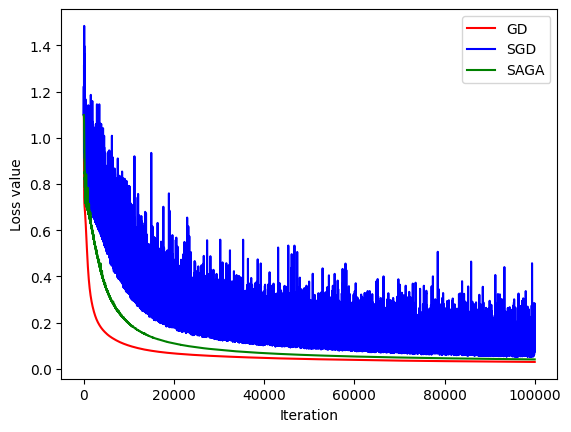

In [88]:
plt.plot(loss_histFull, color = 'r')
plt.plot(loss_histBatch, color = 'b')
plt.plot(loss_histSAGA, color = 'g')
plt.xlabel('Iteration')
plt.ylabel('Loss value')
plt.legend(['GD', 'SGD', 'SAGA'])

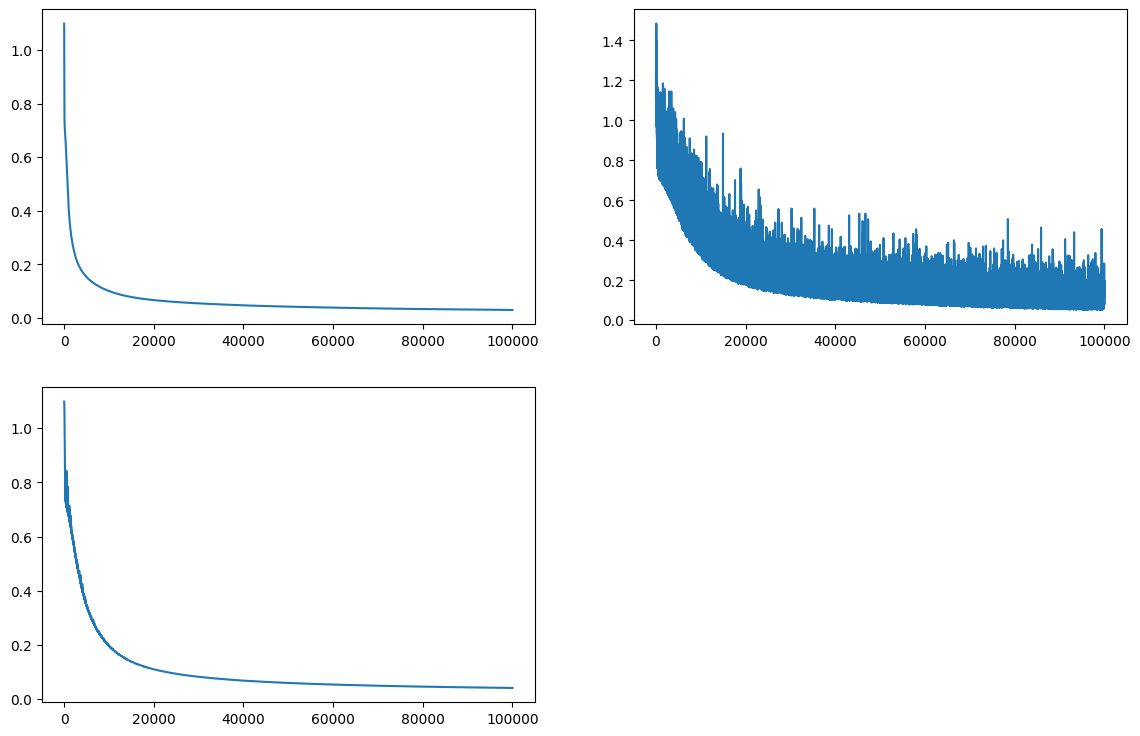

In [11]:
plt.figure(figsize = (14, 9))
plt.subplot(2, 2, 1)
plt.plot(loss_histFull)
plt.subplot(2, 2, 2)
plt.plot(loss_histBatch)
plt.subplot(2, 2, 3)
plt.plot(loss_histSAGA)

Text(0.5, 1.0, '\\#hidden units = 100, accuracy =99.33333333333333\\%')

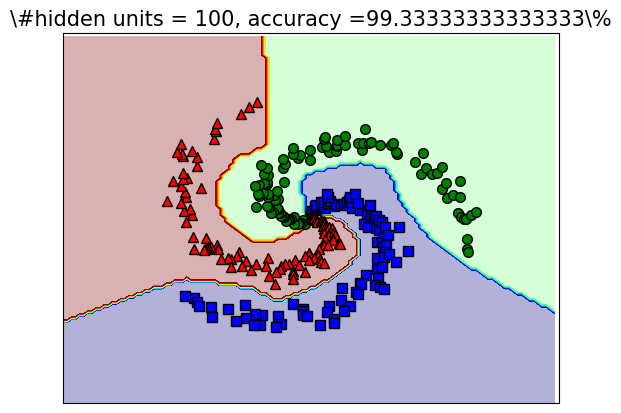

In [16]:
# Visualize results

xm = np.arange(-1.5, 1.5, 0.025)
xlen = len(xm)
ym = np.arange(-1.5, 1.5, 0.025)
ylen = len(ym)
xx, yy = np.meshgrid(xm, ym)


# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# xx.ravel(), yy.ravel()

# print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)


X0 = np.vstack((xx1, yy1)).T
Z = mlp_predict(X0, W1SAGA, b1SAGA, W2SAGA, b2SAGA)
Z = Z.reshape(xx.shape)

plt.clf()
CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha = .3)

# N = 100
# print(N)

plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 7, markeredgecolor = 'k');
plt.plot(X[N:2*N, 0], X[N:2*N, 1], 'go', markersize = 7, markeredgecolor = 'k');
plt.plot(X[2*N:, 0], X[2*N:, 1], 'r^', markersize = 7, markeredgecolor = 'k');

# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xticks(())
plt.yticks(())
str0 = '\#hidden units = ' + str(d1) + ', accuracy =' + str(accSAGA) + '\%'
plt.title(str0, fontsize = 15)

Text(0, 0.5, 'Variance')

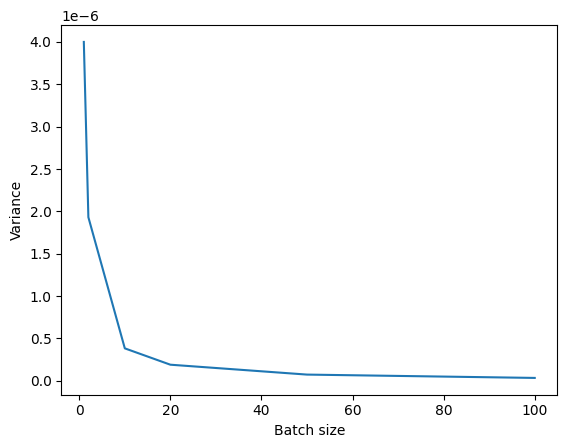

In [35]:
y = np.array([4.00E-06, 1.93E-06, 3.82E-07, 1.89E-07, 7.22E-08, 3.29E-08])
x = [1, 2, 10, 20, 50, 100]
plt.plot(x, y)
plt.xlabel('Batch size')
plt.ylabel('Variance')

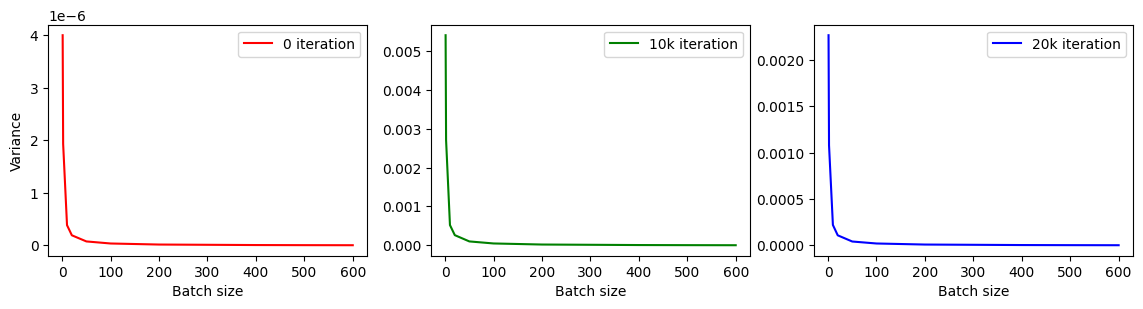

In [61]:
y0 = [4.00E-06, 1.93E-06, 3.82E-07, 1.89E-07, 7.22E-08, 3.29E-08, 1.30E-08, 3.31E-09, 1.31E-09, 2.97E-38]

y10 = [5.42E-03, 2.71E-03, 5.20E-04, 2.60E-04, 9.82E-05, 4.54E-05, 1.79E-05, 4.48E-06, 1.77E-06, 4.14E-36]

y20 = [2.27E-03, 1.08E-03, 2.19E-04, 1.07E-04, 4.01E-05, 1.87E-05, 7.31E-06, 1.86E-06, 7.47E-07, 1.69E-36]

x = [1, 2, 10, 20, 50, 100, 200, 400, 500, 600]



plt.figure(figsize = (14, 3))
plt.subplot(1, 3, 1)
plt.plot(x, y0, color = 'r')
plt.xlabel('Batch size')
plt.ylabel('Variance')
plt.legend(['0 iteration'])
plt.subplot(1, 3, 2)
plt.plot(x, y10, color = 'g')
plt.xlabel('Batch size')
plt.legend(['10k iteration'])
plt.subplot(1, 3, 3)
plt.plot(x, y20, color = 'b')
plt.xlabel('Batch size')
plt.legend(['20k iteration'])




Text(0, 0.5, 'y')

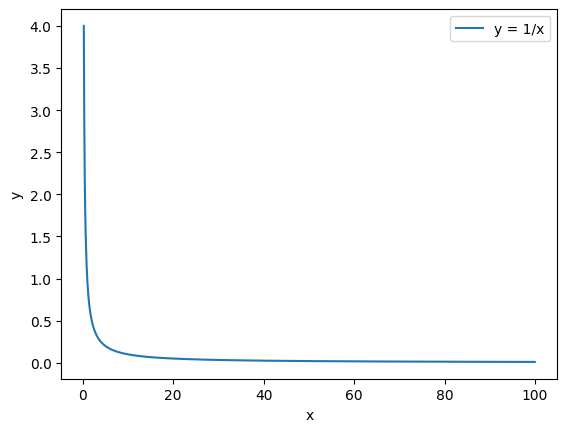

In [64]:
xSample = np.arange(0.25, 100, 0.1)
ySample = 1/(xSample)
plt.plot(xSample, ySample)
plt.legend(['y = 1/x'])
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'ln(Variance ratio)')

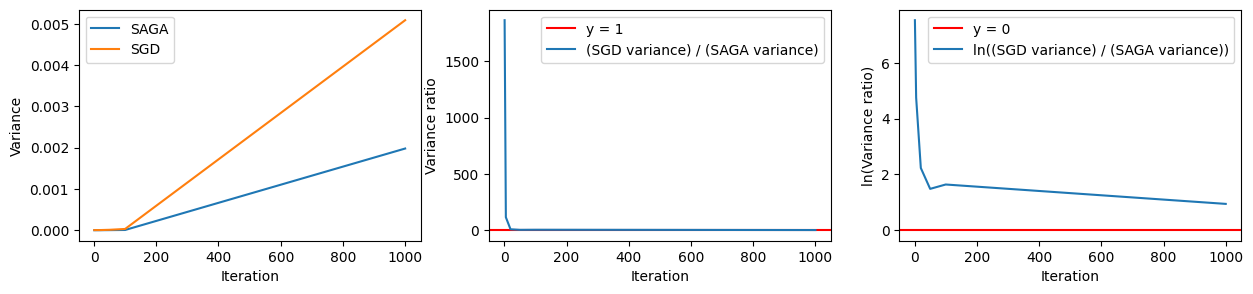

In [86]:
ySAGA = np.array([1.67E-09, 2.76E-08, 4.21E-07, 2.36E-06, 5.96E-06, 1.98E-03])
ySGD =  np.array([3.11E-06, 3.20E-06, 3.92E-06, 1.04E-05, 3.07E-05, 5.09E-03])
xIter = [1, 5, 20, 50, 100, 1000]

plt.figure(figsize = (15, 3))

plt.subplot(1, 3, 1)
plt.plot(xIter, ySAGA)
plt.plot(xIter, ySGD)
plt.legend(['SAGA', 'SGD'])
plt.xlabel('Iteration')
plt.ylabel('Variance')

plt.subplot(1, 3, 2)
plt.axhline(1, color = 'r')
plt.plot(xIter, ySGD/ySAGA)
plt.legend(['y = 1', '(SGD variance) / (SAGA variance)'])
plt.xlabel('Iteration')
plt.ylabel('Variance ratio')

plt.subplot(1, 3, 3)
plt.axhline(0, color = 'r')
plt.plot(xIter, np.log(ySGD/ySAGA))
plt.legend(['y = 0', 'ln((SGD variance) / (SAGA variance))'])
plt.xlabel('Iteration')
plt.ylabel('ln(Variance ratio)')

Text(0, 0.5, 'ln(Variance ratio)')

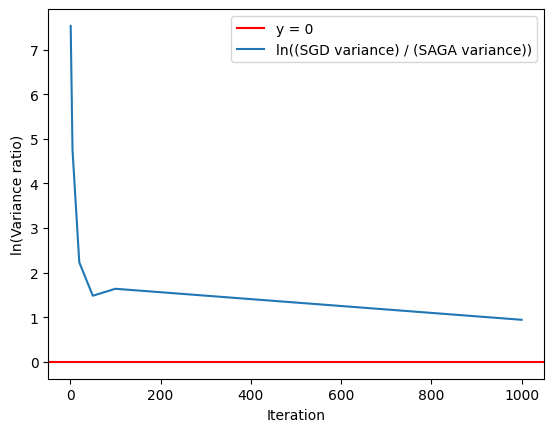

In [82]:
plt.axhline(0, color = 'r')
plt.plot(xIter, np.log(ySGD/ySAGA))
plt.legend(['y = 0', 'ln((SGD variance) / (SAGA variance))'])
plt.xlabel('Iteration')
plt.ylabel('ln(Variance ratio)')